In [ ]:
# Install for GPU acceleration
!pip install setuptools pip wheel --upgrade
!pip install nvidia-pyindex
!pip install nvidia-cuda-runtime-cu12

# Install TensorFlow
!pip install tflite-model-maker
!pip install librosa --upgrade
!pip install tensorflow-datasets==4.8.3

In [3]:
import os
import glob
import random

import soundfile as sf
from IPython.display import Audio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.9.3
Model Maker Version: 0.3.4


In [6]:
dataset_dir = './dataset'
test_dir = './dataset-test'

In [9]:
def get_random_audio_file(samples_dir):
  files = os.path.abspath(os.path.join(samples_dir, '*/*.wav'))
  files_list = glob.glob(files)
  random_audio_path = random.choice(files_list)
  return random_audio_path

def show_sample(audio_path):
  audio_data, sample_rate = sf.read(audio_path) 
  class_name = os.path.basename(os.path.dirname(audio_path))
  print(f'Class: {class_name}')
  print(f'File: {audio_path}')
  print(f'Sample rate: {sample_rate}')
  print(f'Sample length: {len(audio_data)}')

  plt.title(class_name)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

Class: 이륜차주행음
File: d:\Dev2023\audio-model-maker\dataset-test\이륜차주행음\2.이륜자동차_14792_1_mono_16bit.wav
Sample rate: 44100
Sample length: 486378


findfont: Font family ['NanumSquare'] not found. Falling back to DejaVu Sans.
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 52264 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kmwh0\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py

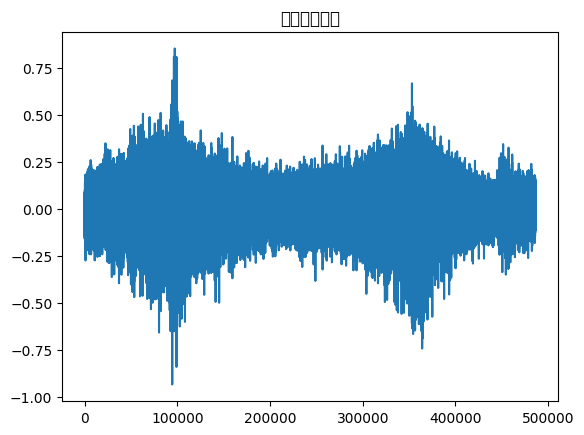

In [10]:
random_audio = get_random_audio_file(test_dir)
show_sample(random_audio)

In [11]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

tf.config.list_physical_devices('GPU')
tf.debugging.set_log_device_placement(False)

train_data_ratio = 0.8
train_data = audio_classifier.DataLoader.from_folder(spec, dataset_dir, cache=True)
train_data, validation_data = train_data.split(train_data_ratio)
test_data = audio_classifier.DataLoader.from_folder(spec, test_dir, cache=True)

batch_size = 25
epochs = 25
model = audio_classifier.create(train_data, spec, validation_data, batch_size, epochs)

INFO:tensorflow:Checkpoints are stored in C:\Users\kmwh0\AppData\Local\Temp\tmpemk432ox
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 24)               24600     
                                                                 
Total params: 24,600
Trainable params: 24,600
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
4514/4514 [==============================] - 2717s 601ms/step - loss: 0.7789 - acc: 0.7852 - val_loss: 0.6441 - val_acc: 0.8491
Epoch 2/25
4514/4514 [==============================] - 19s 4ms/step - loss: 0.5189 - acc: 0.8486 - val_loss: 0.5591 - val_acc: 0.8706
Epoch 3/25
4514/4514 [==============================] - 19s 4ms/step - loss: 0.4831 - acc: 0.8587 - val_loss: 0.4875 - val_acc: 0.8797
Epoch 4/25
4514/4514 [==============================] - 20s 4ms/step - loss: 0.4688

In [12]:
models_path = './models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='noises_model.tflite')

Exporing the TFLite model to ./birds_models
INFO:tensorflow:Assets written to: C:\Users\kmwh0\AppData\Local\Temp\tmp1hrrdmce\assets


INFO:tensorflow:Assets written to: C:\Users\kmwh0\AppData\Local\Temp\tmp1hrrdmce\assets


INFO:tensorflow:TensorFlow Lite model exported successfully: ./birds_models\my_birds_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./birds_models\my_birds_model.tflite
